In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, RocCurveDisplay)
from sklearn.metrics import accuracy_score

In [21]:
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [22]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
COLOR_PALETTE = ["#2E86AB", "#F18F01", "#C73E1D", "#3B1F2B", "#6CBEED"]

In [24]:
df = pd.read_csv(r"C:\Users\shashank\Downloads\Tele customer churn.csv")

In [25]:
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [26]:

df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)


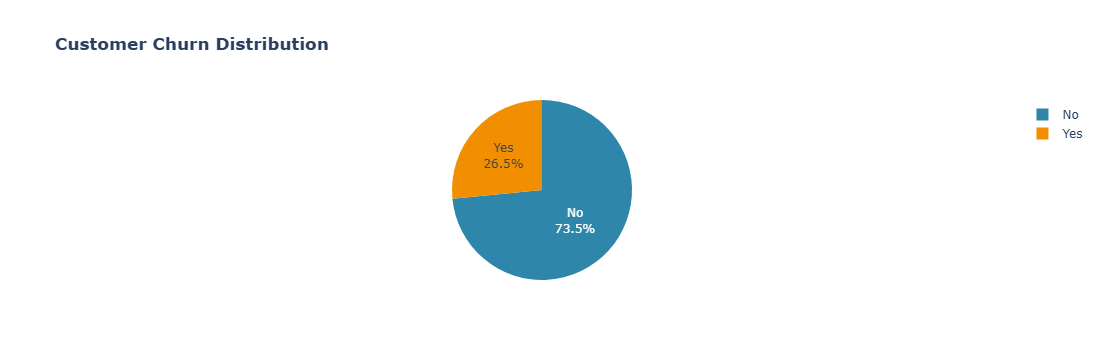

In [27]:
fig1 = px.pie(df, names='Churn', title='<b>Customer Churn Distribution</b>',
             color_discrete_sequence=COLOR_PALETTE)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig1.show()

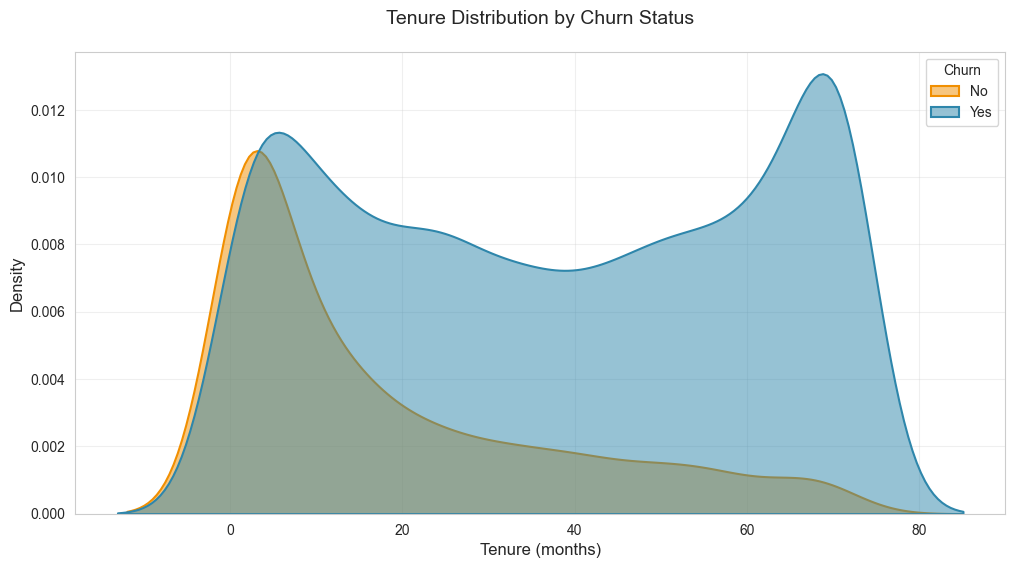

In [28]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, 
            palette=COLOR_PALETTE[:2], alpha=.5, linewidth=1.5)
plt.title('Tenure Distribution by Churn Status', fontsize=14, pad=20)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

fig2 = px.scatter(df, x='tenure', y='MonthlyCharges', color='Churn',
                 size='TotalCharges', hover_name='customerID',
                 title='<b>Monthly Charges vs Tenure</b>',
                 color_discrete_sequence=COLOR_PALETTE)
fig2.update_layout(xaxis_title='Tenure (months)',
                  yaxis_title='Monthly Charges ($)')
fig2.show()


# Create new features

In [30]:
df['TenureSegment'] = pd.cut(df['tenure'], bins=[0, 3, 24, 72], 
                            labels=['New (0-3m)', 'Established (3-24m)', 'Long-term (>24m)'])
df['ValueRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)

# Encode categorical variables

In [31]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'TenureSegment']

In [32]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Encode target

In [33]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


## 3. Model Training

# Prepare features

In [34]:
features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ValueRatio'] + cat_cols
X = df[features]
y = df['Churn']


# Train-test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features

In [36]:
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ValueRatio']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [37]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [38]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_


In [46]:
best_rf

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

# 4.1 Confusion Matrix Heatmap

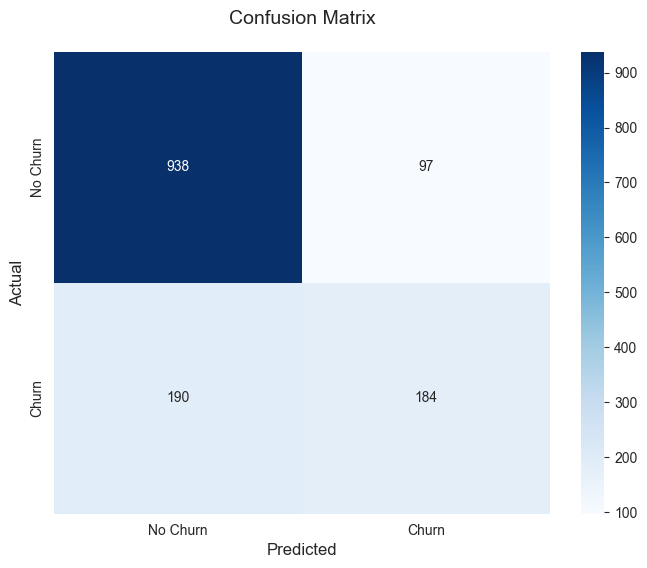

In [39]:
plt.figure(figsize=(8, 6))
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Churn', 'Churn'],
           yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# 4.2 ROC Curve

<Figure size 800x600 with 0 Axes>

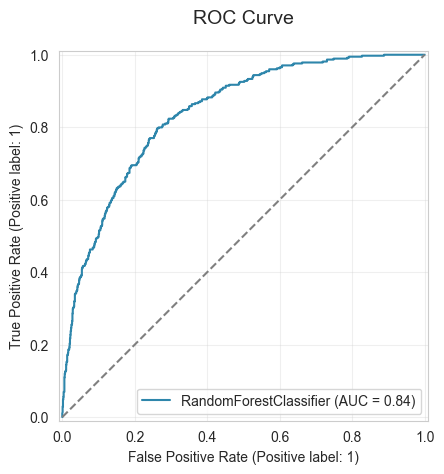

In [40]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, color=COLOR_PALETTE[0])
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve', fontsize=14, pad=20)
plt.show()

# 4.3 Precision-Recall Curve

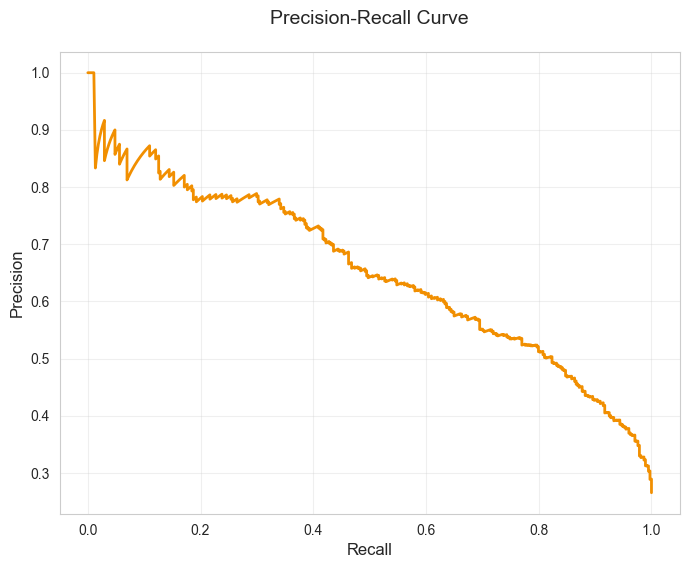

In [41]:
precision, recall, _ = precision_recall_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color=COLOR_PALETTE[1], lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, pad=20)
plt.show()


# Add predictions to dataframe

In [52]:
df['ChurnProbability'] = best_rf.predict_proba(X)[:, 1]

# Create segments

In [53]:
conditions = [
    (df['ChurnProbability'] >= 0.65),
    (df['ChurnProbability'] <= 0.15),
    (df['ChurnProbability'] > 0.15) & (df['ChurnProbability'] < 0.65)
]
choices = ['High Risk', 'Loyal', 'Medium Risk']
df['Segment'] = np.select(conditions, choices, default='Other')

# 5.1 Segment Distribution


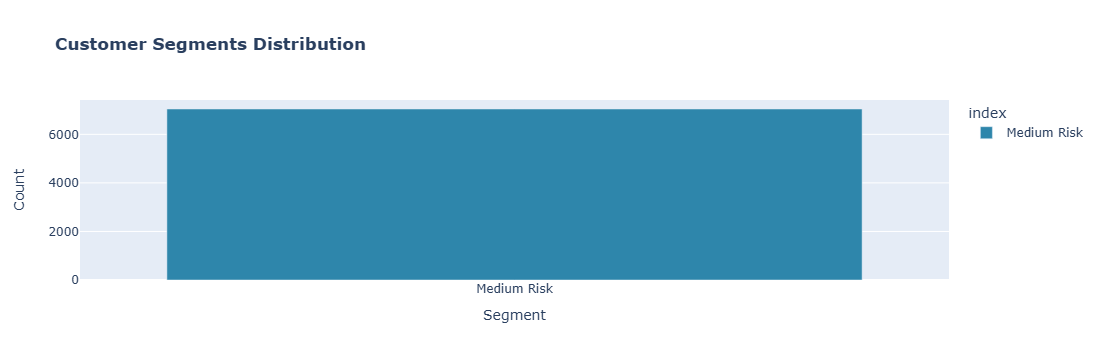

In [54]:
segment_counts = df['Segment'].value_counts()
fig = px.bar(segment_counts, 
             x=segment_counts.index, 
             y=segment_counts.values,
             color=segment_counts.index,
             color_discrete_sequence=COLOR_PALETTE,
             title='<b>Customer Segments Distribution</b>')
fig.update_layout(xaxis_title='Segment', yaxis_title='Count')
fig.show()

In [55]:
segment_analysis = df.groupby('Segment').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'ChurnProbability': 'mean'
}).reset_index()

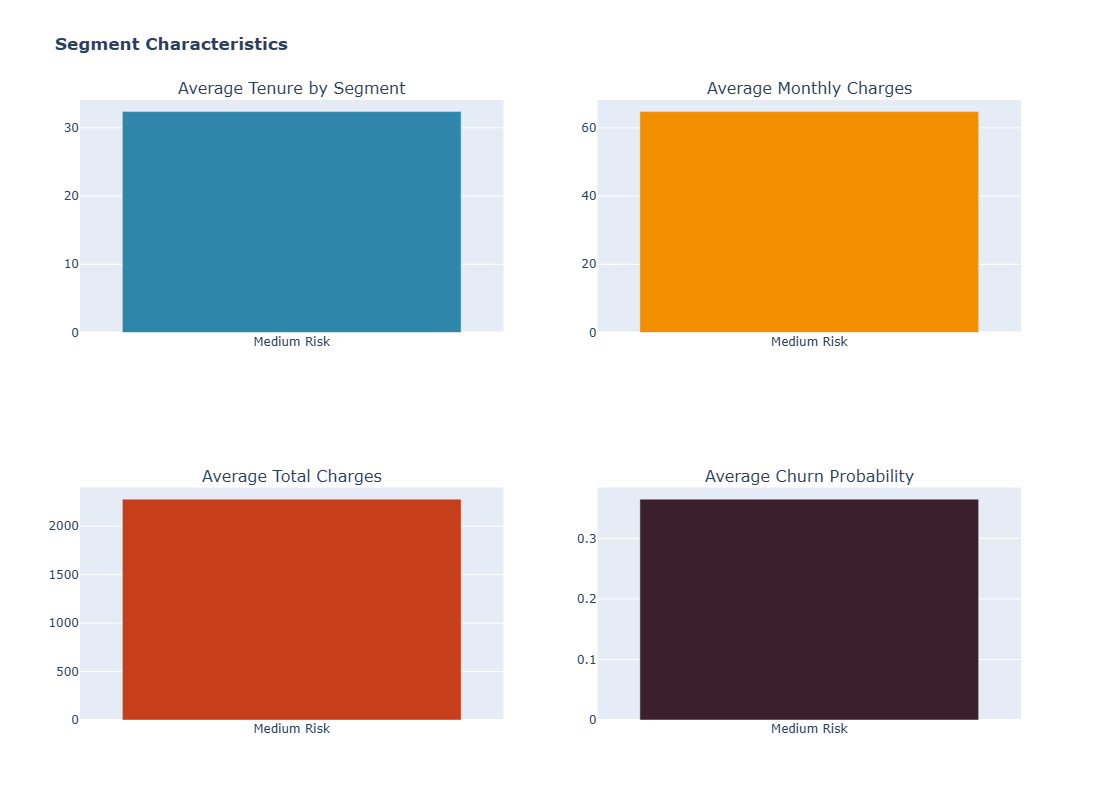

In [56]:
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Average Tenure by Segment", 
    "Average Monthly Charges",
    "Average Total Charges",
    "Average Churn Probability"))

fig.add_trace(
    go.Bar(x=segment_analysis['Segment'], y=segment_analysis['tenure'],
          name='Tenure', marker_color=COLOR_PALETTE[0]),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=segment_analysis['Segment'], y=segment_analysis['MonthlyCharges'],
          name='Monthly Charges', marker_color=COLOR_PALETTE[1]),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=segment_analysis['Segment'], y=segment_analysis['TotalCharges'],
          name='Total Charges', marker_color=COLOR_PALETTE[2]),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=segment_analysis['Segment'], y=segment_analysis['ChurnProbability'],
          name='Churn Probability', marker_color=COLOR_PALETTE[3]),
    row=2, col=2
)

fig.update_layout(height=800, width=1000, title_text="<b>Segment Characteristics</b>", showlegend=False)
fig.show()